In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Full imports
import torch
from blockgen.configs import VoxelConfig, DiffusionConfig
from blockgen.utils import create_model_and_trainer, create_dataloaders
from blockgen.inference import DiffusionInference3D
from scripts.generate import load_model_for_inference

/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB


In [5]:
# Configs
voxel_config = VoxelConfig(
    use_rgb=True,
    default_color=[0.5, 0.5, 0.5],
    alpha_weight=1.0,
    rgb_weight=1.0,
    use_simple_mse=False
)

diffusion_config = DiffusionConfig(
    num_timesteps=1000,
    use_ema=True,
    ema_decay=0.9999,
    ema_update_after_step=0,
    ema_device=device,
    seed=42
)

In [59]:
# Create model and trainer
trainer, model = create_model_and_trainer(
    voxel_config=voxel_config,
    diffusion_config=diffusion_config,
    resolution=32,
    device=device
)

Total parameters: 120099908


In [17]:
train_loader, test_loader = create_dataloaders(
    voxel_dir="objaverse_data_voxelized",
    annotation_file="objaverse_data/annotations.json",
    config=diffusion_config,
    config_voxel=voxel_config,
    batch_size=3
)

Finding voxel files: 400620it [04:16, 1561.99it/s] 


Found 400620 unique files (including augmentations)

Sample paths:
  objaverse_data_voxelized/hf-objaverse-v1/glbs/000-000/e406fd52136949a688d2ed5879361021.pt
  objaverse_data_voxelized/hf-objaverse-v1/glbs/000-000/e406fd52136949a688d2ed5879361021_aug1.pt
  objaverse_data_voxelized/hf-objaverse-v1/glbs/000-000/e406fd52136949a688d2ed5879361021_aug2.pt
  objaverse_data_voxelized/hf-objaverse-v1/glbs/000-000/e406fd52136949a688d2ed5879361021_aug3.pt
  objaverse_data_voxelized/hf-objaverse-v1/glbs/000-000/14be2940b43541168e157a7ccfb60560.pt


In [ ]:
metrics = trainer.train(
    train_loader,
    test_loader,
    total_steps=60_000,
    save_every=5_000,
    eval_every=10_000,
    save_dir='runs/experiment_color_60k',
    checkpoint_path='/scratch/students/2024-fall-sp-pabdel/3D-BlockGen/runs/experiment_color_60k/checkpoints/checkpoint_step_50000.pth'
)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(metrics['training_losses'])
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(metrics['test_steps'], metrics['test_losses'])
plt.title('Test Loss')
plt.xlabel('Step')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [1]:
import sys
import torch
pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{pyt_version_str}"
])
!pip install iopath
!pip install --no-deps --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
#print(f"pip install --no-deps --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html")

AttributeError: 'NoneType' object has no attribute 'replace'

In [64]:
model = load_model_for_inference('runs/experiment_color_60k/models/model_step_60000', voxel_config=voxel_config, diffusion_config=diffusion_config, device=device, ema=True)

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 10000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet3DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


Loaded EMA model weights


In [65]:
# Inference
inferencer = DiffusionInference3D(
    model=model,
    noise_scheduler=model.noise_scheduler,
    config=voxel_config,
    device=device
)

In [ ]:
samples = inferencer.sample(
    prompt="Banana",
    num_samples=1,
    image_size=(32, 32, 32),
    show_intermediate=False,
    guidance_scale=20,
    use_mean_init=False,
    py3d=False,
    use_rotations=True
)

Sampling Steps:  22%|███████████████████████                                                                                  | 220/1000 [01:37<05:47,  2.25it/s]

In [ ]:
inferencer.visualize_samples(samples, threshold=0.5)

Number of vertices: 37552
Max face index: 37551
Number of faces: 103268


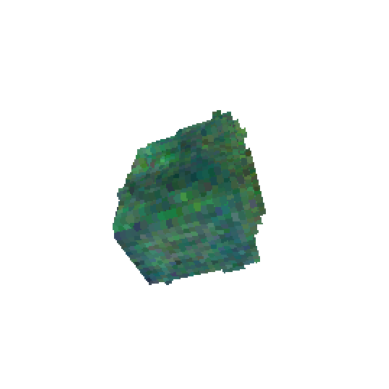

In [42]:
inferencer.visualize_samples_p3d(samples[0], threshold=0.5)

RGB range: [0.000, 0.973]
Alpha range: [0.000, 1.000]
Occupied voxels: 299 (0.91% of volume)


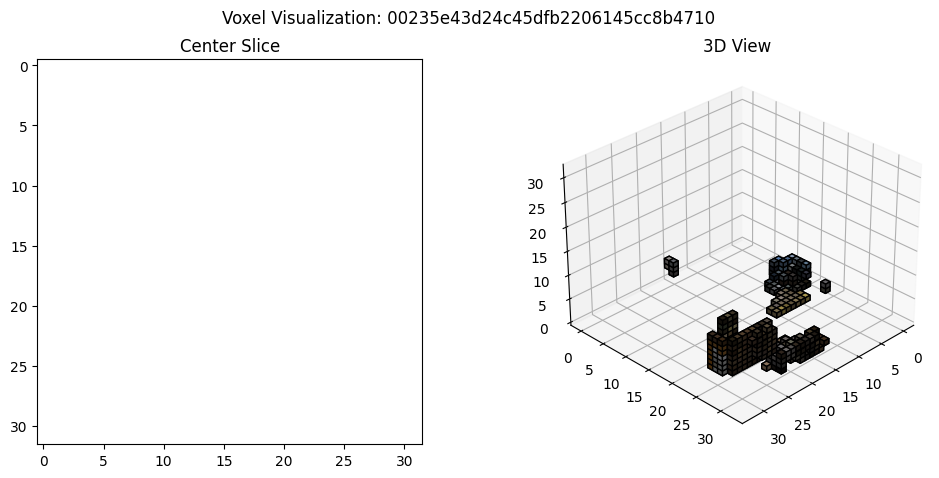

In [31]:
from blockgen.utils import plot_voxel_tensor

plot_voxel_tensor("objaverse_data_voxelized/hf-objaverse-v1/glbs/000-003/00235e43d24c45dfb2206145cc8b4710.pt")

Number of vertices: 2392
Max face index: 2391
Number of faces: 6578


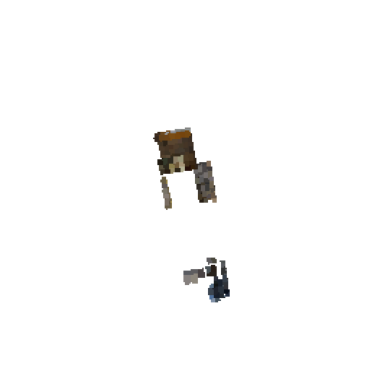

In [29]:
inferencer.visualize_samples_p3d(torch.load("objaverse_data_voxelized/hf-objaverse-v1/glbs/000-003/00235e43d24c45dfb2206145cc8b4710.pt", map_location=torch.device("cuda")))